# Import Libraries

In [1]:
import os
import shap
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers, regularizers

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# Load the data

In [2]:
train = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')
test = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/test.csv')
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])

# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


# Model Parameters

In [3]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 400
WIDTH = 400
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

# Image Preprocessing

In [4]:
import cv2
import numpy as np

def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the original image and
    returns the cropped image with appropriate channels.
    
    :param img: A NumPy Array that will be cropped (grayscale or RGB)
    :param tol: The tolerance used for masking
    
    :return: A NumPy array containing the cropped image
    """
    # If the image is grayscale (2D array)
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    
    # If the image has 3 channels (RGB)
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:  # If the image is too dark and crops everything
            return img  # Return the original image
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img

def preprocess_image(image, sigmaX=10):
    """
    Preprocessing pipeline:
    1. Convert BGR to RGB (if applicable)
    2. Crop the image from gray regions
    3. Resize the image to 400x400
    4. Apply Gaussian blur to enhance robustness
    5. Normalize the image
    
    :param image: A NumPy Array of the image (grayscale or color)
    :param sigmaX: Value used to apply GaussianBlur
    
    :return: A NumPy array containing the preprocessed image
    """
    # Check if the image is grayscale (2D array)
    if image.ndim == 2:
        is_gray = True
    else:
        is_gray = False
        # Convert BGR to RGB (since OpenCV loads color images as BGR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Crop the image from gray regions
    cropped_image = crop_image_from_gray(image)
    
    # Ensure the cropped image is 800x800 (if larger, center crop)
    height, width = cropped_image.shape[:2]
    if height > 800 and width > 800:
        startx = width // 2 - (800 // 2)
        starty = height // 2 - (800 // 2)
        cropped_image = cropped_image[starty:starty+800, startx:startx+800]
    
    # Resize the image to 400x400
    resized_image = cv2.resize(cropped_image, (400, 400))
    
    # Apply Gaussian blur for robustness
    if is_gray:
        preprocessed_image = cv2.addWeighted(resized_image, 4, 
                                             cv2.GaussianBlur(resized_image, (0, 0), sigmaX), -4, 128)
    else:
        preprocessed_image = cv2.addWeighted(resized_image, 4, 
                                             cv2.GaussianBlur(resized_image, (0, 0), sigmaX), -4, 128)
    
    # Normalize the image (convert to float32 and scale by 1/255)
    preprocessed_image = preprocessed_image.astype(np.float32) / 255.0
    
    return preprocessed_image


# Visualize the Preprocessing Image 

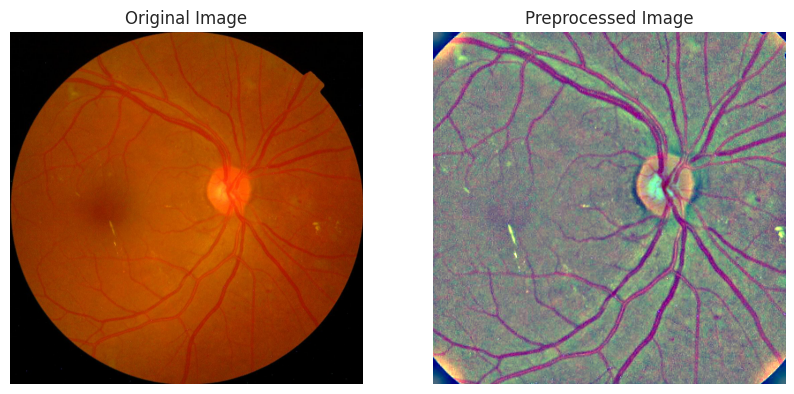

In [5]:
# Load an example image (you can replace 'your_image.jpg' with any image path)
image_path = '/kaggle/input/aptos2019-blindness-detection/test_images/096d6bb6546b.png'
image = cv2.imread(image_path)

# Preprocess the image
preprocessed_image = preprocess_image(image)

# Display the original and preprocessed images using matplotlib
plt.figure(figsize=(10, 5))

# Show original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Show preprocessed image
plt.subplot(1, 2, 2)
plt.imshow(preprocessed_image)
plt.title('Preprocessed Image')
plt.axis('off')

plt.show()

# Train test split

In [6]:
#X_train, X_val = train_test_split(train, test_size=0.2, random_state=123)
X_train, X_test = train_test_split(train, test_size=0.2, random_state=123)

# Data Generator

In [7]:
train_datagen=ImageDataGenerator( 
                                 rotation_range=360,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 validation_split=0.1,
                                 preprocessing_function=preprocess_image)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=X_train,
    directory="/kaggle/input/aptos2019-blindness-detection/train_images",
    x_col="id_code",
    y_col="diagnosis",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    target_size=(HEIGHT, WIDTH),
    seed=0,
    subset='training')

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=X_train,
    directory="/kaggle/input/aptos2019-blindness-detection/train_images",
    x_col="id_code",
    y_col="diagnosis",
    class_mode="categorical", 
    batch_size=BATCH_SIZE,   
    target_size=(HEIGHT,WIDTH),
    seed=0,
    subset= 'validation')

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=X_test,
        directory = "/kaggle/input/aptos2019-blindness-detection/train_images",
        x_col="id_code",
        y_col="diagnosis",
        batch_size=1,
        class_mode="categorical",
        shuffle=False,
        target_size=(HEIGHT, WIDTH),
        seed=0)

Found 2637 validated image filenames belonging to 5 classes.
Found 292 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


# Model

In [8]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    
    # Use EfficientNetB0 as the base model instead of ResNet50
    base_model = EfficientNetB0(weights='imagenet', 
                                include_top=False,
                                input_tensor=input_tensor)
    
    # Add global average pooling and dense layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.7)(x)
    x = Dense(2048, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)  # Fully connected layer
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)  # Output layer for classification
    
    # Create the model
    model = Model(inputs=input_tensor, outputs=final_output)
    
    return model

In [9]:
# Define the model
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

# Freeze all layers initially
for layer in model.layers:
    layer.trainable = False

# Unfreeze the last 5 layers for fine-tuning
for i in range(-5, 0):
    model.layers[i].trainable = True

# Compute class weights to handle imbalanced data
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(train['diagnosis'].astype('int').values), 
    y=train['diagnosis'].astype('int').values
)

# Compile the model with Adam optimizer and categorical cross-entropy loss
metric_list = ["accuracy"]
optimizer = optimizers.Adam(learning_rate=WARMUP_LEARNING_RATE)  # Ensure the correct learning rate is used
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metric_list)

# Print the model summary
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 400, 400,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 400, 400,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 400, 400,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 400, 400,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 401, 401,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 200, 200,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 200, 200,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 200, 200,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 200, 200,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 200, 200,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 200, 200,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 200, 200,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 200, 200,  │        512 │ block1a_se_excit

 Total params: 6,683,304 (25.49 MB)

 Trainable params: 2,633,733 (10.05 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [10]:
# Define steps per epoch
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

In [11]:
from sklearn.utils import class_weight
# Compute class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train['diagnosis'].astype('int').values),
    y=train['diagnosis'].astype('int').values
)

# Create a class weights dictionary
class_weights_dict = {i: class_weights_array[i] for i in range(len(class_weights_array))}

# Define steps per epoch
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

# Fit the model
history_warmup = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=WARMUP_EPOCHS,
    class_weight=class_weights_dict,  # Use the dictionary here
    verbose=1
).history


Epoch 1/2


I0000 00:00:1729784569.506540     111 service.cc:145] XLA service 0x793b38005170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729784569.506605     111 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/329 ━━━━━━━━━━━━━━━━━━━━ 4:07:47 45s/step - accuracy: 0.2500 - loss: 17.8705

I0000 00:00:1729784591.687337     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


329/329 ━━━━━━━━━━━━━━━━━━━━ 578s 2s/step - accuracy: 0.2052 - loss: 6.3167 - val_accuracy: 0.0833 - val_loss: 1.8210
Epoch 2/2
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.2500 - loss: 1.8474 - val_accuracy: 0.0000e+00 - val_loss: 1.8306


# Fine tune the complete model


In [31]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',  metrics=metric_list)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 400, 400,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 400, 400,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 400, 400,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 400, 400,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 401, 401,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 200, 200,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 200, 200,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 200, 200,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 200, 200,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 200, 200,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 200, 200,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 200, 200,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 200, 200,  │        512 │ block1a_se_excit

 Total params: 6,683,304 (25.49 MB)

 Trainable params: 6,641,281 (25.33 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
history_finetunning = model.fit(train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          class_weight=class_weights_dict,
                                          verbose=1).history

# Model loss Graph

In [ ]:
history = {'loss': history_warmup['loss'] + history_finetunning['loss'], 
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'], 
           'accuracy': history_warmup['accuracy'] + history_finetunning['accuracy'], 
           'val_accuracy': history_warmup['val_accuracy'] + history_finetunning['val_accuracy']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['accuracy'], label='Train accuracy')
ax2.plot(history['val_accuracy'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

# Model Evaluation 

In [ ]:
# Create empty arays to keep the predictions and labels
lastFullTrainPred = np.empty((0, N_CLASSES))
lastFullTrainLabels = np.empty((0, N_CLASSES))
lastFullValPred = np.empty((0, N_CLASSES))
lastFullValLabels = np.empty((0, N_CLASSES))

# Add train predictions and labels
for i in range(STEP_SIZE_TRAIN+1):
    im, lbl = next(train_generator)
    scores = model.predict(im, batch_size=train_generator.batch_size)
    lastFullTrainPred = np.append(lastFullTrainPred, scores, axis=0)
    lastFullTrainLabels = np.append(lastFullTrainLabels, lbl, axis=0)

# Add validation predictions and labels
for i in range(STEP_SIZE_VALID+1):
    im, lbl = next(valid_generator)
    scores = model.predict(im, batch_size=valid_generator.batch_size)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
    
    
lastFullComPred = np.concatenate((lastFullTrainPred, lastFullValPred))
lastFullComLabels = np.concatenate((lastFullTrainLabels, lastFullValLabels))
complete_labels = [np.argmax(label) for label in lastFullComLabels]

train_preds = [np.argmax(pred) for pred in lastFullTrainPred]
train_labels = [np.argmax(label) for label in lastFullTrainLabels]
validation_preds = [np.argmax(pred) for pred in lastFullValPred]
validation_labels = [np.argmax(label) for label in lastFullValLabels]

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7))
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
train_cnf_matrix = confusion_matrix(train_labels, train_preds)
validation_cnf_matrix = confusion_matrix(validation_labels, validation_preds)

train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax1).set_title('Train')
sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap=sns.cubehelix_palette(8), ax=ax2).set_title('Validation')
plt.show()

# Quadratic Weighted Kappa

In [ ]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds,train_labels, weights='quadratic'))
print("Validation Cohen Kappa score: %.3f" % cohen_kappa_score(validation_preds, validation_labels, weights='quadratic'))
print("Complete set Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds+validation_preds, train_labels+validation_labels, weights='quadratic'))

In [13]:
from tensorflow.keras.models import load_model

# Load the model from the output directory
model_loaded = load_model('/kaggle/input/efficient-model-400x400-top-model/tensorflow2/default/1/top efficient B0 multi.h5')  # Adjust path if necessary

# Verify that the model is loaded
model_loaded.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 400, 400,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 400, 400,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 400, 400,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 400, 400,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 401, 401,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 200, 200,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 200, 200,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 200, 200,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 200, 200,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 200, 200,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 200, 200,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 200, 200,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 200, 200,  │        512 │ block1a_se_excit

 Total params: 6,683,306 (25.49 MB)

 Trainable params: 6,641,281 (25.33 MB)

 Non-trainable params: 42,023 (164.16 KB)

 Optimizer params: 2 (12.00 B)

# Evalution On Test Data

In [14]:
# Example: Use model to make predictions on test data
test_loss, test_acc = model_loaded.evaluate(test_generator)
print("Test accuracy:", test_acc)

# Make predictions
predictions = model_loaded.predict(test_generator)


733/733 ━━━━━━━━━━━━━━━━━━━━ 112s 142ms/step - accuracy: 0.7699 - loss: 0.6461
Test accuracy: 0.7557981014251709
733/733 ━━━━━━━━━━━━━━━━━━━━ 93s 121ms/step


In [16]:
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

733/733 ━━━━━━━━━━━━━━━━━━━━ 88s 121ms/step - accuracy: 0.7699 - loss: 0.6461
733/733 ━━━━━━━━━━━━━━━━━━━━ 88s 120ms/step


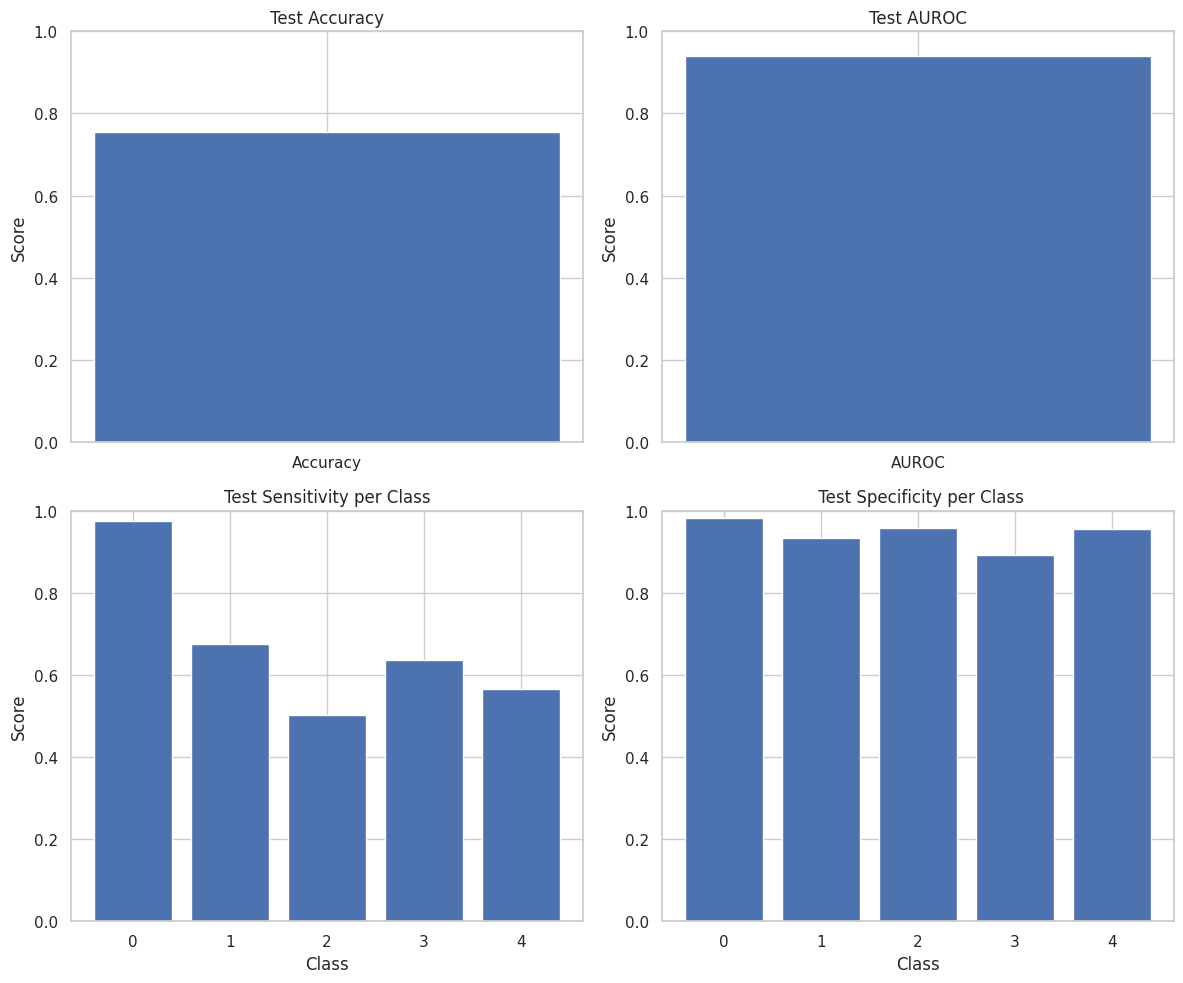

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, confusion_matrix
import numpy as np
import tensorflow as tf

# Evaluate on validation data
loss, acc = model_loaded.evaluate(test_generator, verbose=1)

# Get predictions on validation data
test_predictions = model_loaded.predict(test_generator)

# Convert predictions to class labels
test_predicted_classes = np.argmax(test_predictions, axis=1)

# Get the true labels from the validation generator
test_true_labels = test_generator.classes

# Accuracy
accuracy = accuracy_score(test_true_labels, test_predicted_classes)

# AUROC (for multi-class, one-vs-rest approach)
auroc = roc_auc_score(tf.keras.utils.to_categorical(test_true_labels, num_classes=5), test_predictions, multi_class='ovr')

# Sensitivity (recall)
sensitivity = recall_score(test_true_labels, test_predicted_classes, average=None)

# Specificity from confusion matrix
cm = confusion_matrix(test_true_labels, test_predicted_classes)
specificity = []
for i in range(len(cm)):
    tn = sum(sum(cm)) - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity.append(tn / (tn + fp))

# Plotting Accuracy, AUROC, Sensitivity, and Specificity

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Accuracy plot
axs[0, 0].bar(["Accuracy"], [accuracy])
axs[0, 0].set_ylim([0, 1])
axs[0, 0].set_title("Test Accuracy")
axs[0, 0].set_ylabel("Score")

# AUROC plot
axs[0, 1].bar(["AUROC"], [auroc])
axs[0, 1].set_ylim([0, 1])
axs[0, 1].set_title("Test AUROC")
axs[0, 1].set_ylabel("Score")

# Sensitivity plot (per class)
axs[1, 0].bar(np.arange(len(sensitivity)), sensitivity)
axs[1, 0].set_ylim([0, 1])
axs[1, 0].set_title("Test Sensitivity per Class")
axs[1, 0].set_ylabel("Score")
axs[1, 0].set_xlabel("Class")

# Specificity plot (per class)
axs[1, 1].bar(np.arange(len(specificity)), specificity)
axs[1, 1].set_ylim([0, 1])
axs[1, 1].set_title(" Test Specificity per Class")
axs[1, 1].set_ylabel("Score")
axs[1, 1].set_xlabel("Class")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [23]:
print('auroc score for test data:',auroc)
print('sensitivity score for test data:',sensitivity)
print('specificity score for test data:',specificity)

auroc score for test data: 0.9392787586205664
sensitivity score for test data: [0.9740634  0.675      0.50234742 0.63636364 0.56666667]
specificity score for test data: [0.9818652849740933, 0.9326186830015314, 0.9576923076923077, 0.8928571428571429, 0.9539375928677564]


# ROC Curve

In [24]:
import numpy as np
# Get the true labels and predicted probabilities from the test generator
test_labels = []
test_preds = []

# Loop through the test generator to get predictions and true labels
for i in range(STEP_SIZE_TEST):  # Adjust to match the number of test batches
    im, lbl = next(test_generator)  # Get a batch of images and labels
    scores = model_loaded.predict(im, batch_size=test_generator.batch_size)  # Predict probabilities
    test_preds.append(scores)  # Append predicted probabilities
    test_labels.append(lbl)  # Append true labels

# Convert lists to numpy arrays
test_preds = np.vstack(test_preds)  # Stack all predictions
test_labels = np.vstack(test_labels)  # Stack all true labels


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━

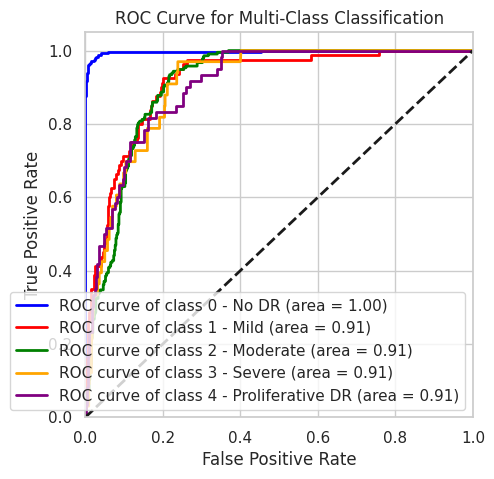

In [51]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Assuming you have 5 classes
n_classes = 5
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']

# Initialize dictionaries for False Positive Rate (fpr), True Positive Rate (tpr), and roc_auc
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], test_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(5, 5))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for a random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

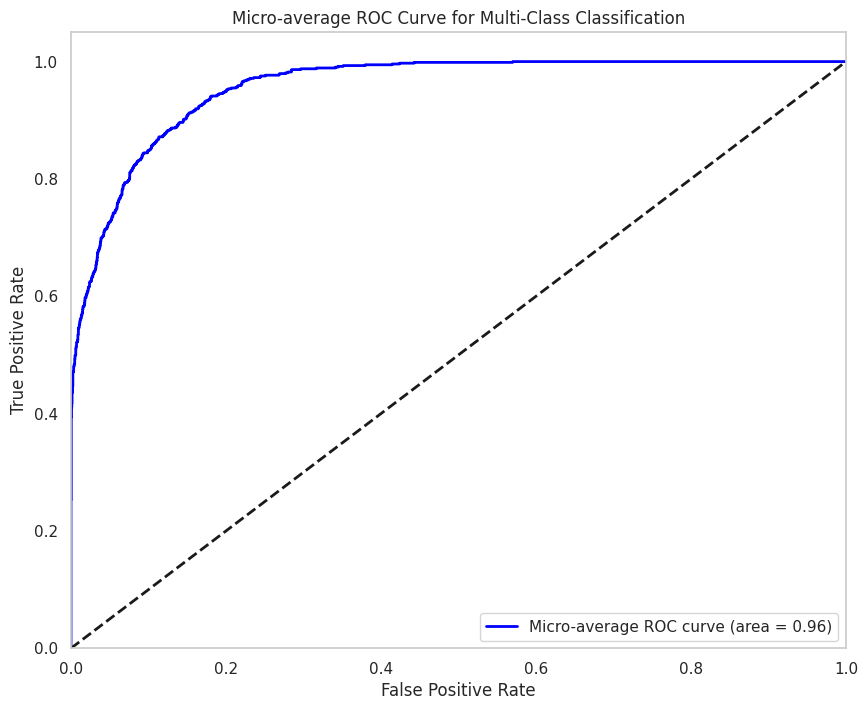

Micro-average AUC: 0.96


In [26]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the true labels and predicted probabilities from the test generator
test_labels = []
test_preds = []

# Loop through the test generator to get predictions and true labels
for i in range(STEP_SIZE_TEST):  # Adjust to match the number of test batches
    im, lbl = next(test_generator)  # Get a batch of images and labels
    scores = model_loaded.predict(im, batch_size=test_generator.batch_size)  # Predict probabilities
    test_preds.append(scores)  # Append predicted probabilities
    test_labels.append(lbl)  # Append true labels

# Convert lists to numpy arrays
test_preds = np.vstack(test_preds)  # Stack all predictions
test_labels = np.vstack(test_labels)  # Stack all true labels

# Assuming you have 5 classes
n_classes = 5

# Convert labels to binary format
# Create binary labels for the true labels
binary_labels = np.zeros((test_labels.shape[0], n_classes))
for i in range(test_labels.shape[0]):
    binary_labels[i, int(np.argmax(test_labels[i]))] = 1

# Calculate ROC curve and AUC for the micro-average
fpr, tpr, _ = roc_curve(binary_labels.ravel(), test_preds.ravel())
roc_auc = auc(fpr, tpr)

# Plot the micro-average ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for a random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.grid()  # Optional: add a grid for better readability
plt.show()

# Print the micro-average AUC
print(f'Micro-average AUC: {roc_auc:.2f}')


# Save model

In [ ]:
model.save("top efficient B0 multi.h5")

# Multi Level Efficient 

In [28]:

from tensorflow.keras import layers, Model

In [29]:
# Load the EfficientNet-B0 base model without the top (fully connected) layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(400, 400, 3))

# Extracting features at different levels
block3_output = base_model.get_layer('block3a_expand_activation').output  # (32, 100, 100)
block5_output = base_model.get_layer('block5a_expand_activation').output  # (24, 50, 50)
block7_output = base_model.get_layer('block7a_expand_activation').output  # (40, 13, 13)

# Bilinear Interpolation to resize feature maps to (25x25)
block3_resized = layers.Lambda(lambda x: tf.image.resize(x, (25, 25), method='bilinear'))(block3_output)
block5_resized = layers.Lambda(lambda x: tf.image.resize(x, (25, 25), method='bilinear'))(block5_output)
block7_resized = layers.Lambda(lambda x: tf.image.resize(x, (25, 25), method='bilinear'))(block7_output)

# Apply 1x1 convolution to unify the channel depth across feature maps
block3_depth_adjusted = layers.Conv2D(320, (1, 1), padding='same', activation='relu')(block3_resized)
block5_depth_adjusted = layers.Conv2D(320, (1, 1), padding='same', activation='relu')(block5_resized)
block7_depth_adjusted = layers.Conv2D(320, (1, 1), padding='same', activation='relu')(block7_resized)

# Concatenate the resized and depth-adjusted feature maps
concatenated_features = layers.Concatenate()([block3_depth_adjusted, block5_depth_adjusted, block7_depth_adjusted])

# Apply a 1x1 convolution to reduce the depth of concatenated features
conv1x1 = layers.Conv2D(320, (1, 1), padding='same', activation='relu')(concatenated_features)

# Adaptive Average Pooling to reduce to (1, 1, 320)
adaptive_avg_pool = layers.GlobalAveragePooling2D()(conv1x1)

# Final fully connected layer for classification (5 classes as per your use case)
output = layers.Dense(5, activation='softmax')(adaptive_avg_pool)

# Create the final model
multi_level_efficientnet_b0 = Model(inputs=base_model.input, outputs=output)

# Compile the model
multi_level_efficientnet_b0.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary to see the architecture
multi_level_efficientnet_b0.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 400, 400,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 400, 400,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 400, 400,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 400, 400,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 401, 401,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 200, 200,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 200, 200,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 200, 200,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 200, 200,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 200, 200,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 200, 200,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 200, 200,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 200, 200,  │        512 │ block1a_se_excit

 Total params: 4,016,568 (15.32 MB)

 Trainable params: 3,980,049 (15.18 MB)

 Non-trainable params: 36,519 (142.66 KB)

In [32]:
history_multi_level_efficientB0 = multi_level_efficientnet_b0.fit(train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          class_weight=class_weights_dict,
                                          verbose=1).history

Epoch 1/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 552s 1s/step - accuracy: 0.4338 - loss: 1.6304 - val_accuracy: 0.1111 - val_loss: 3.6056 - learning_rate: 0.0010
Epoch 2/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5000 - loss: 1.6683 - val_accuracy: 0.0000e+00 - val_loss: 3.7792 - learning_rate: 0.0010
Epoch 3/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 430s 1s/step - accuracy: 0.6299 - loss: 1.1333 - val_accuracy: 0.5278 - val_loss: 1.2566 - learning_rate: 0.0010
Epoch 4/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6250 - loss: 0.4391 - val_accuracy: 0.5000 - val_loss: 1.3490 - learning_rate: 0.0010
Epoch 5/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 429s 1s/step - accuracy: 0.6747 - loss: 1.0025 - val_accuracy: 0.7222 - val_loss: 0.5839 - learning_rate: 0.0010
Epoch 6/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7500 - loss: 1.3966 - val_accuracy: 1.0000 - val_loss: 0.2558 - learning_rate: 0.0010
Epoch 7/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 428s 1s/step - accuracy: 0.7215 - loss: 

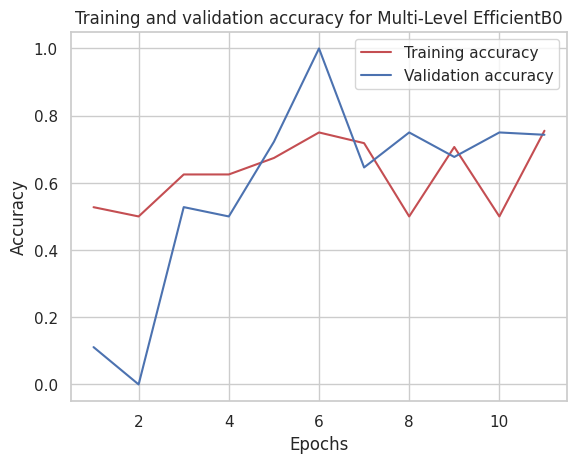

In [33]:
# Assuming 'history_multi_level_efficientB0' is a dictionary
epochs = range(1, len(history_multi_level_efficientB0["accuracy"]) + 1)
train_acc = history_multi_level_efficientB0["accuracy"]
val_acc = history_multi_level_efficientB0["val_accuracy"]

# Plotting the training and validation accuracy
import matplotlib.pyplot as plt

plt.figure()
plt.plot(epochs, train_acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy for Multi-Level EfficientB0")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


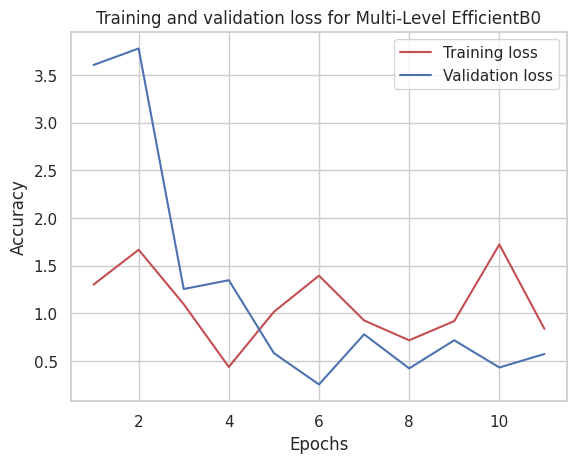

In [34]:
# Assuming 'history_multi_level_efficientB0' is a dictionary
epochs = range(1, len(history_multi_level_efficientB0["loss"]) + 1)
train_acc = history_multi_level_efficientB0["loss"]
val_acc = history_multi_level_efficientB0["val_loss"]

# Plotting the training and validation accuracy
import matplotlib.pyplot as plt

plt.figure()
plt.plot(epochs, train_acc, "r", label="Training loss")
plt.plot(epochs, val_acc, "b", label="Validation loss")
plt.title("Training and validation loss for Multi-Level EfficientB0")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [21]:
 multi_level_efficientnet_b0.save("top multi efficient B0 multi.h5")

# Evaluate on test data

In [49]:
# Example: Use model to make predictions on test data
test_loss, test_acc = multi_level_efficientnet_b0.evaluate(test_generator)
print("Test accuracy:", test_acc)

# Make predictions
predictions_Ml = multi_level_efficientnet_b0.predict(test_generator)


733/733 ━━━━━━━━━━━━━━━━━━━━ 88s 120ms/step - accuracy: 0.7079 - loss: 0.6588
Test accuracy: 0.6930422782897949
733/733 ━━━━━━━━━━━━━━━━━━━━ 87s 119ms/step


In [36]:
#predictions using argmax
predicted_classes = np.argmax(predictions,axis=1)

In [37]:
true_labels = test_generator.classes

In [38]:
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

In [39]:
import numpy as np

# Get the true labels and predicted probabilities from the test generator
test_labels = []
test_preds = []

# Loop through the test generator to get predictions and true labels
for i in range(STEP_SIZE_TEST):  # Adjust to match the number of test batches
    im, lbl = next(test_generator)  # Get a batch of images and labels
    scores = multi_level_efficientnet_b0.predict(im, batch_size=test_generator.batch_size)  # Predict probabilities
    test_preds.append(scores)  # Append predicted probabilities
    test_labels.append(lbl)  # Append true labels

# Convert lists to numpy arrays
test_preds = np.vstack(test_preds)  # Stack all predictions
test_labels = np.vstack(test_labels)  # Stack all true labels


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━

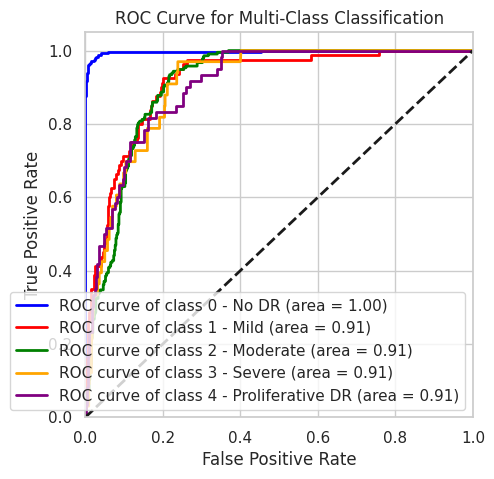

In [46]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Assuming you have 5 classes
n_classes = 5
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']

# Initialize dictionaries for False Positive Rate (fpr), True Positive Rate (tpr), and roc_auc
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], test_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(5, 5))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for a random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

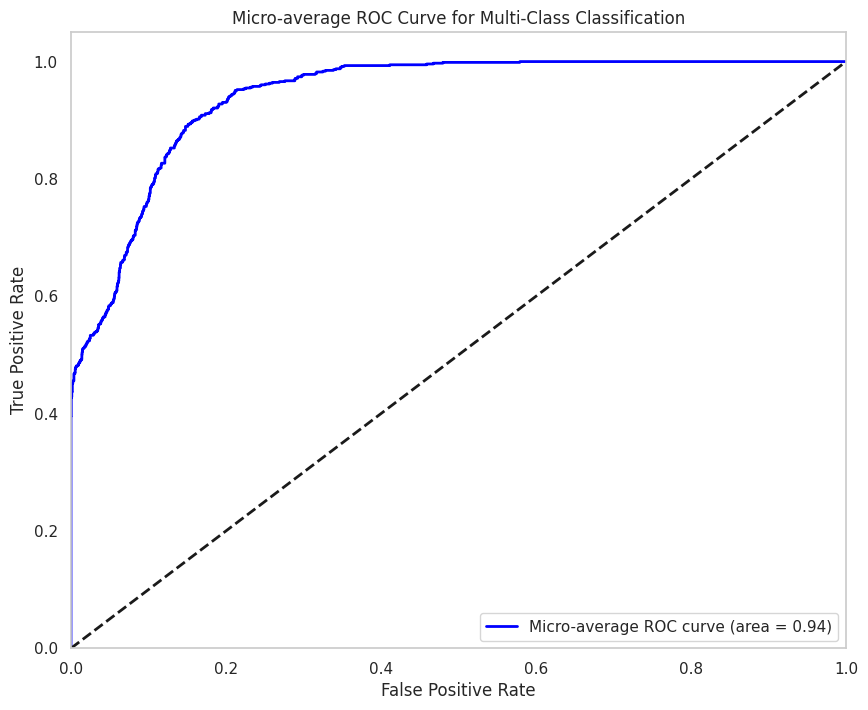

Micro-average AUC: 0.94


In [41]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the true labels and predicted probabilities from the test generator
test_labels = []
test_preds = []

# Loop through the test generator to get predictions and true labels
for i in range(STEP_SIZE_TEST):  # Adjust to match the number of test batches
    im, lbl = next(test_generator)  # Get a batch of images and labels
    scores = multi_level_efficientnet_b0.predict(im, batch_size=test_generator.batch_size)  # Predict probabilities
    test_preds.append(scores)  # Append predicted probabilities
    test_labels.append(lbl)  # Append true labels

# Convert lists to numpy arrays
test_preds = np.vstack(test_preds)  # Stack all predictions
test_labels = np.vstack(test_labels)  # Stack all true labels

# Assuming you have 5 classes
n_classes = 5

# Convert labels to binary format
# Create binary labels for the true labels
binary_labels = np.zeros((test_labels.shape[0], n_classes))
for i in range(test_labels.shape[0]):
    binary_labels[i, int(np.argmax(test_labels[i]))] = 1

# Calculate ROC curve and AUC for the micro-average
fpr, tpr, _ = roc_curve(binary_labels.ravel(), test_preds.ravel())
roc_auc = auc(fpr, tpr)

# Plot the micro-average ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for a random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.grid()  # Optional: add a grid for better readability
plt.show()

# Print the micro-average AUC
print(f'Micro-average AUC: {roc_auc:.2f}')


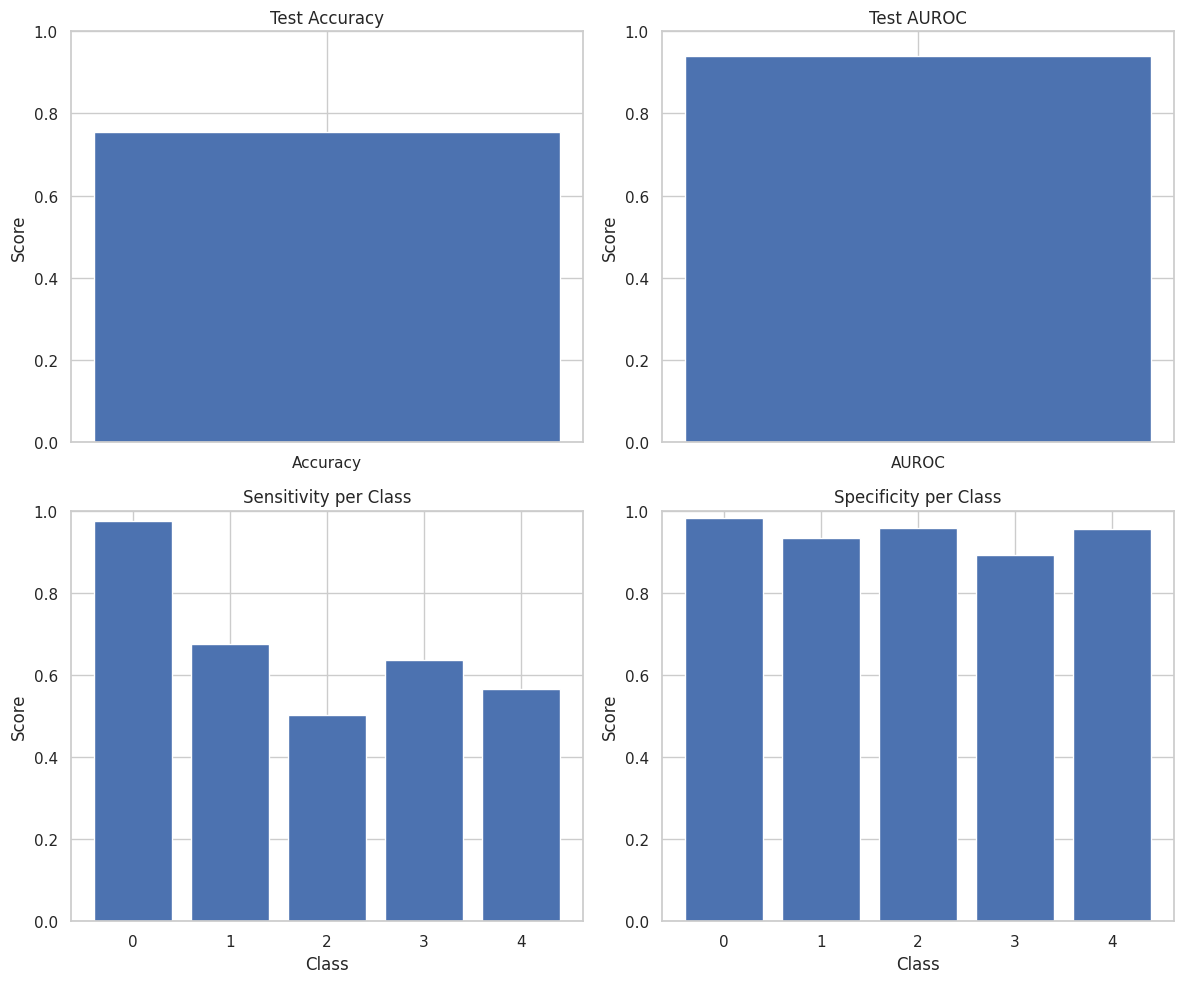

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, confusion_matrix
import numpy as np

# Accuracy
accuracy = accuracy_score(test_true_labels, test_predicted_classes)

# AUROC (for multi-class, one-vs-rest approach)
auroc = roc_auc_score(tf.keras.utils.to_categorical(test_true_labels, num_classes=5), test_predictions, multi_class='ovr')

# Sensitivity (recall)
sensitivity = recall_score(test_true_labels, test_predicted_classes, average=None)

# Specificity from confusion matrix
cm = confusion_matrix(test_true_labels, test_predicted_classes)
specificity = []
for i in range(len(cm)):
    tn = sum(sum(cm)) - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity.append(tn / (tn + fp))

# Plotting Accuracy, AUROC, Sensitivity, and Specificity

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Accuracy plot
axs[0, 0].bar(["Accuracy"], [accuracy])
axs[0, 0].set_ylim([0, 1])
axs[0, 0].set_title("Test Accuracy")
axs[0, 0].set_ylabel("Score")

# AUROC plot
axs[0, 1].bar(["AUROC"], [auroc])
axs[0, 1].set_ylim([0, 1])
axs[0, 1].set_title("Test AUROC")
axs[0, 1].set_ylabel("Score")

# Sensitivity plot (per class)
axs[1, 0].bar(np.arange(len(sensitivity)), sensitivity)
axs[1, 0].set_ylim([0, 1])
axs[1, 0].set_title("Sensitivity per Class")
axs[1, 0].set_ylabel("Score")
axs[1, 0].set_xlabel("Class")

# Specificity plot (per class)
axs[1, 1].bar(np.arange(len(specificity)), specificity)
axs[1, 1].set_ylim([0, 1])
axs[1, 1].set_title("Specificity per Class")
axs[1, 1].set_ylabel("Score")
axs[1, 1].set_xlabel("Class")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [48]:
print('auroc score for test data:',auroc)
print('specificity score for test data:',specificity)
print('sensitivity score for test data:',sensitivity)

auroc score for test data: 0.9392787586205664
specificity score for test data: [0.9818652849740933, 0.9326186830015314, 0.9576923076923077, 0.8928571428571429, 0.9539375928677564]
sensitivity score for test data: [0.9740634  0.675      0.50234742 0.63636364 0.56666667]


In [52]:
#ensemble the model 
ensemble_model =np.mean([predictions,predictions_Ml],axis=0)

In [54]:
ensemble_final_preds = np.argmax(ensemble_model,axis=1)

In [57]:
ensemble_acc = accuracy_score(true_labels,ensemble_final_preds)

In [58]:
print("ensemble accuracy :",ensemble_acc)

ensemble accuracy : 0.6930422919508867


In [60]:
!pip install edafa


In [61]:
from edafa import ClassPredictor

In [ ]:
import numpy as np

class TTAPredictor:
    def __init__(self, model, config):
        self.model = model
        self.augs = config.get('augs', ['NO'])  # No augmentation by default
        self.mean = config.get('mean', 'ARITH') # Arithmetic mean by default

    def augment_image(self, image, augmentation):
        """ Apply the selected augmentation to the image """
        if augmentation == 'FLIP_LR':
            return np.flip(image, axis=2)  # Flip Left-Right
        elif augmentation == 'FLIP_UD':
            return np.flip(image, axis=1)  # Flip Up-Down
        # Add more augmentations like rotation, scaling, etc., if needed
        return image  # Return the original if no augmentation
    
    def predict_tta(self, test_generator):
        """ Predict with Test-Time Augmentation (TTA) """
        predictions = []

        for batch in test_generator:
            # Extract images and ignore labels
            images, _ = batch

            batch_predictions = []

            for aug in self.augs:
                # Apply augmentation and ensure the shape is consistent
                augmented_batch = np.array([self.augment_image(img, aug) for img in images])
                
                # Ensure augmented batch retains the correct shape
                assert augmented_batch.shape == images.shape, f"Shape mismatch: {augmented_batch.shape} vs {images.shape}"

                # Get predictions for the augmented images
                preds = self.model.predict(augmented_batch)
                batch_predictions.append(preds)

            # Compute mean of the predictions
            if self.mean == 'ARITH':
                final_preds = np.mean(batch_predictions, axis=0)  # Arithmetic mean
            elif self.mean == 'GEOMETRIC':
                final_preds = np.exp(np.mean(np.log(batch_predictions), axis=0))  # Geometric mean
            else:
                final_preds = np.mean(batch_predictions, axis=0)  # Default to arithmetic

            predictions.append(final_preds)

        return np.concatenate(predictions, axis=0)


# Configuration for augmentations
conf = {
    "augs": ["NO", "FLIP_LR", "FLIP_UD"],  # No augmentation, Flip Left-Right, Flip Up-Down
    "mean": "ARITH"  # Arithmetic mean for averaging predictions
}

# Initialize TTA predictor with your model and config
tta_predictor = TTAPredictor(model_loaded, conf)

# Use the TTA predictor to get augmented predictions
y_pred_aug = tta_predictor.predict_tta(test_generator)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━